In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from functools import partial
import pandas as pd
from tqdm import tqdm_notebook

# Comparison of T-test power to the Mann-Whitney test power

Power of the criterion is the probability of rejecting $H_0$ given that it is false.

In [4]:
def simulate_data(mean_1, mean_2, n_range, plots=True, hist=False):  
    n_1, n_2=np.random.randint(*n_range, 2)
    S1, S2=np.random.normal(mean_1, size=n_1), np.random.normal(mean_2, size=n_2)
    if plots:
        plt.figure(figsize=[10, 8])
        sns.distplot(S1, label='mean={}'.format(mean_1), hist=hist)
        sns.distplot(S2, label='mean={}'.format(mean_2), hist=hist)
        plt.legend()
    return S1, S2

def plot_norms(means, std, disc):
    plt.figure(figsize=[10, 8])
    min_rng=min(np.array(means)-4*np.array(std))
    max_rng=max(np.array(means)+4*np.array(std))
    rng=np.linspace(min_rng, max_rng, disc)
    for m, s in zip(means, std):
        plt.plot(rng, [stats.norm.pdf(x, m, s) for x in rng], label='mean={}\nstd={}'.format(m, s))
    plt.legend()
    plt.xticks(range(int(np.floor(min_rng)), int(np.ceil(max_rng))+1))
    plt.grid()

def get_power(generator, n_iters, plots=True):
    data=[generator() for _ in range(n_iters)]
    t_vals=[stats.ttest_ind(*samples)[1] for samples in data]
    u_vals=[stats.mannwhitneyu(*samples)[1] for samples in data]
    th_range=np.linspace(0, 1, 101)
    t_power=[np.sum(t_vals<th)/len(t_vals) for th in th_range]
    u_power=[np.sum(u_vals<th)/len(u_vals) for th in th_range]
    if plots:
        plt.figure(figsize=[12, 10])
        plt.plot(th_range, t_power, label='T-test power')
        plt.plot(th_range, u_power, label='Mann-Whitney power')
        plt.legend()
        plt.xlabel('p-value threshold')
        plt.ylabel('power')
    return th_range, t_power, u_power

Let's compare power of the two test in three different situations, when the true mean of one sample is 1 $\sigma$ away from the true mean of the other, 2 $\sigma$ awat and 3 $\sigma$ away.

Tests will be computed for independent samples taken from such distribution, number of observation in each sample is a random variable that follows discrete uniform distribution: $a=20$, $b=30$.

### Case 1

General population distributions:

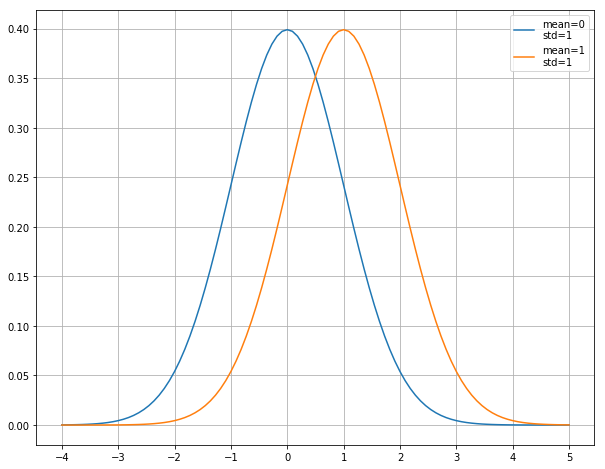

In [39]:
plot_norms([0, 1], [1, 1], 100)

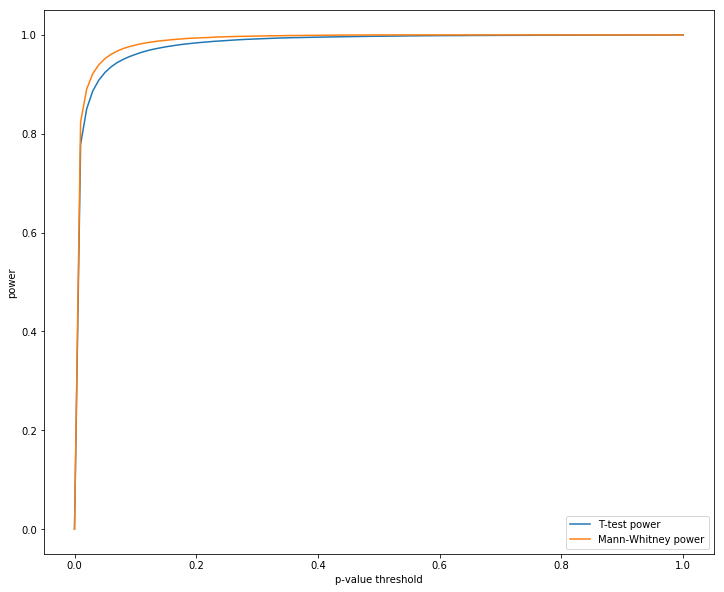

In [64]:
case_1=partial(simulate_data, 0, 1, (20, 30), False, False) # generating function
res=get_power(case_1, 100000, True)

### Case 2

General population distributions:

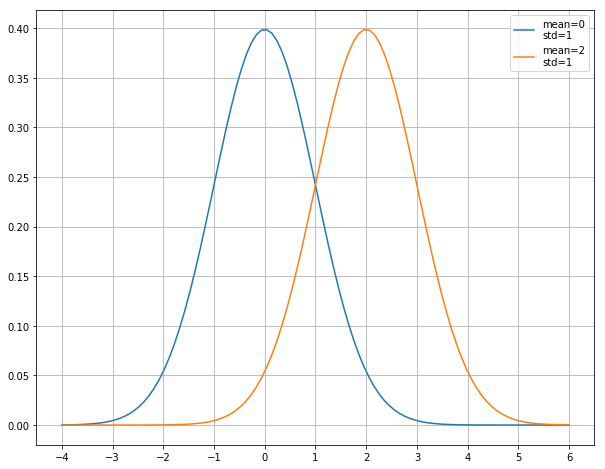

In [42]:
plot_norms([0, 2], [1, 1], 100)

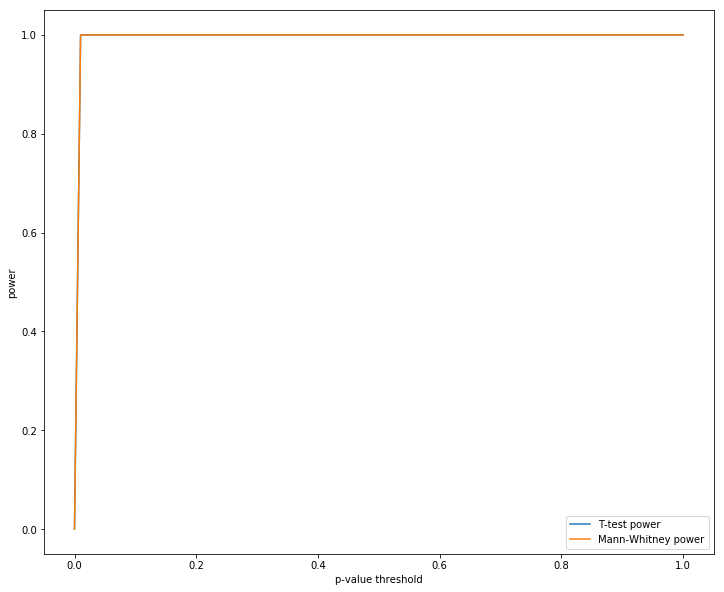

In [65]:
case_2=partial(simulate_data, 0, 2, (20, 30), False, False)
res_2=get_power(case_2, 100000, True)

### Case 3

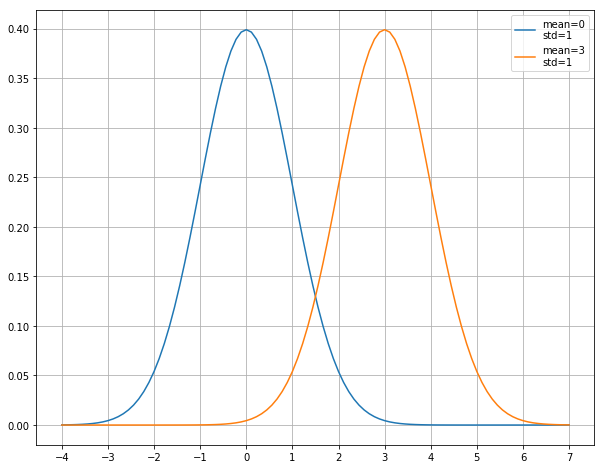

In [41]:
plot_norms([0, 3], [1, 1], 100)

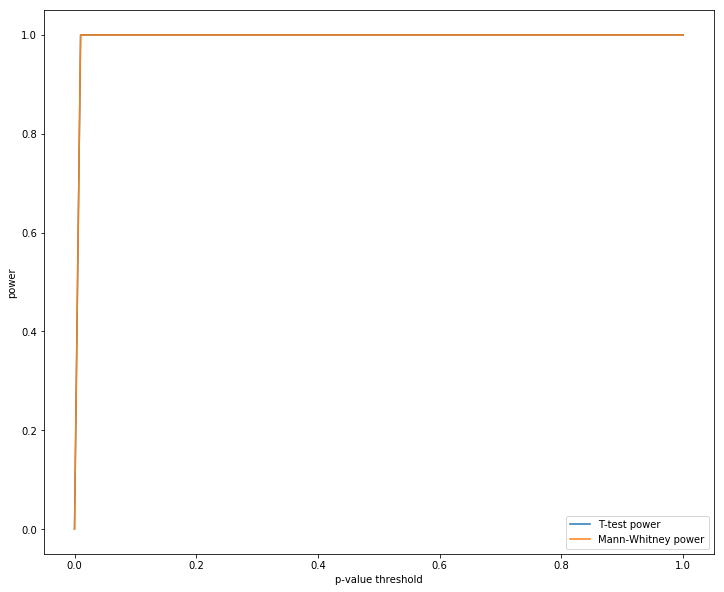

In [66]:
case_3=partial(simulate_data, 0, 3, (20, 30), False, False)
res_3=get_power(case_3, 100000, True)

Judging by the plots obtained, Mann-Whitney test is more powerful than T-test, when the difference betwenn true means is small. But as this difference gets larger two test start to behave in similar way in terms of power.

Let's do one more final test for even smallet difference, 0.5 $\sigma$.

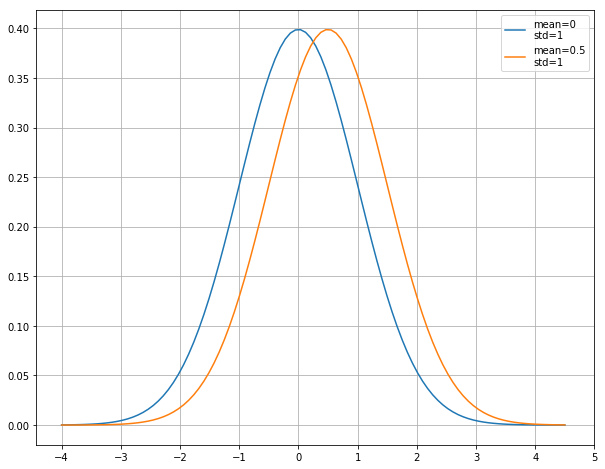

In [74]:
plot_norms([0, 0.5], [1, 1], 100)

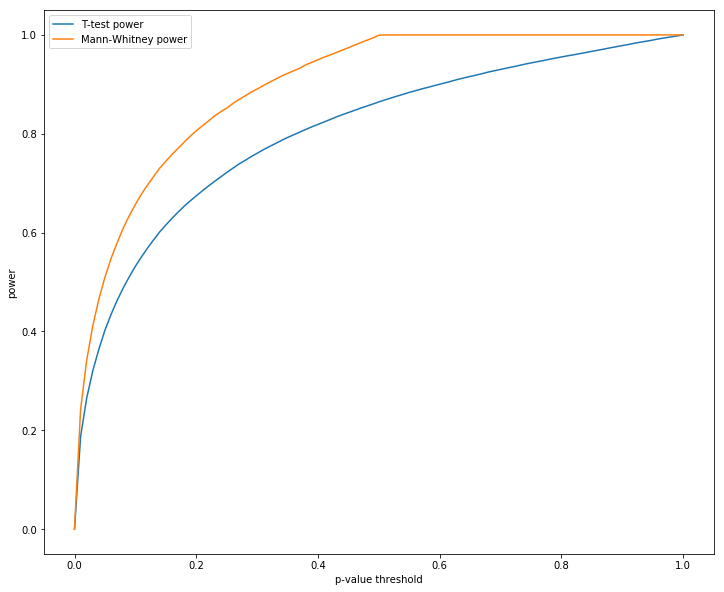

In [75]:
case_4=partial(simulate_data, 0, 0.5, (20, 30), False, False)
res_4=get_power(case_4, 100000, True)

This result is consistent with the statement above.

### Pearson and Spearman coefficients

Let's compare Pearson and Spearman correlation coefficients computed for two components of the sample taken from bivariate Normal ditiribution.

Suppose that we have two sample from the strandard Normal distribution $N(0,1)$: $S_1$ and $S_2$. If we generated $S_3$ such that $S_3=\rho S_1+\sqrt{1-\rho^2}S_2$. $S_3$ and $S_1$ wil be two correlated samples with correlation coefficient $\rho$. If we want to specify mean and standard deviation that differ from standard ones the following transformation should be applied: 

$T_1=\mu_1+\sigma_1S_1$ 

$T_2=\mu_2+\sigma_2S_2$. 

$T_1\sim N(\mu_1, \sigma_1)$

$T_2\sim N(\mu_2, \sigma_2)$

In [46]:
def get_corr_samples(means, stds, corr, n):
    S1=np.random.normal(size=n)
    S2=np.random.normal(size=n)
    S3=corr*S1+np.sqrt(1-corr**2)*S2
    X1=means[0]+stds[0]*S1
    X2=means[1]+stds[1]*S3
    return X1, X2

def compare_coeff(means, stds, corr, N_range, n_iters, plot=True):
    Pearson=[]
    Pearson_err=[]
    Spearman=[]
    Spearman_err=[]
    rng=range(*N_range)
    for N in rng:
        data=[get_corr_samples(means, stds, corr, N) for _ in range(n_iters)]
        tmp=np.array([[stats.pearsonr(*samples)[0], stats.spearmanr(*samples)[0]]\
                              for samples in data])
        Pearson.append(tmp[:, 0].mean())
        Pearson_err.append(tmp[:, 0].std())
        Spearman.append(tmp[:, 1].mean())
        Spearman_err.append(tmp[:,1].std())
    if plot:
        plt.figure(figsize=[12, 10])
        plt.plot(N_range[:-1], [corr]*2, color='r', label='True correlation={}'.format(corr), linestyle='--')
        plt.errorbar(rng, Pearson, yerr=Pearson_err, label='Pearson coefficient', alpha=0.7)
        plt.errorbar(rng, Spearman, yerr=Spearman_err, label='Spearman coefficient', alpha=0.7)
        plt.grid()
        plt.legend()
        plt.xlabel('Number of observations in sample')
        plt.ylabel('Correlation coefficient value')
    return Pearson, Pearson_err, Spearman, Spearman_err

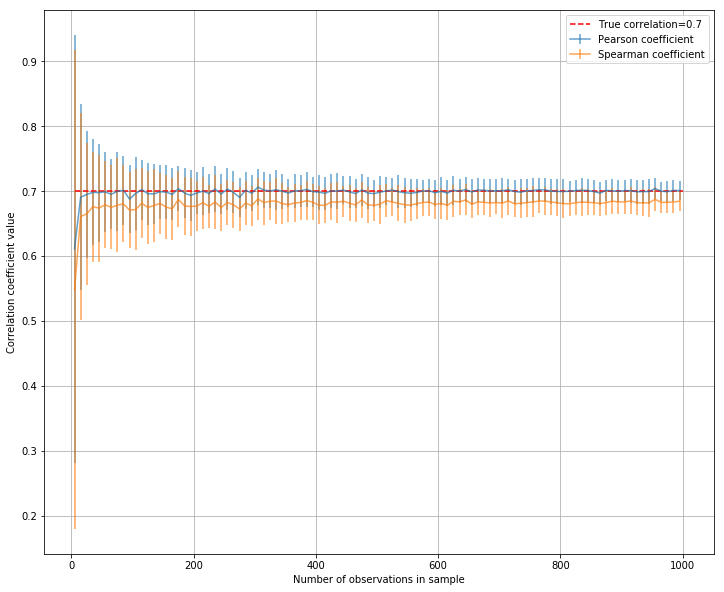

In [47]:
res_corr=compare_coeff([0, 0], [1, 1], 0.7, (5, 1001, 10), 100)

According to the simulation result, values of Pearson and Spearman correlation coefficients are similar for Normal data, but not identical.

# Multiple comparisons problem and Bonferroni correction

In [31]:
def mcomp_simulate_data(orig_mean, orig_std, N, N_same, n_range, eps=0.05):
    if N_same>N:
        raise ValueError
        
    dif_means=[]
    c=0
    while len(dif_means)<N-N_same:
        tmp=np.random.normal(orig_mean, orig_std)
        if abs(tmp)>=orig_mean+eps*orig_std:
            dif_means.append(tmp)
    same_means=[orig_mean]*N_same
    means=dif_means+same_means
    data=[np.random.normal(orig_mean, orig_std, np.random.randint(*n_range))]\
    +[np.random.normal(mean, orig_std, np.random.randint(*n_range)) for mean in means]
    return data, N_same

def summarize(data, N_same, alpha=0.05, bonferr=False):
    orig_sample=data[0]
    N_diff=len(data[1:])-N_same
    if bonferr: alpha=alpha/(len(data)-1)
    p_vals=[stats.ttest_ind(orig_sample, sample)[1] for sample in data[1:]]
    Pos_p_vals=p_vals[:N_diff]
    Neg_p_vals=p_vals[N_diff:]
    assert(len(Neg_p_vals)==N_same)
    TP_CP=np.sum(np.array(Pos_p_vals)<alpha)
    TP_CN=N_diff-TP_CP
    TN_CP=np.sum(np.array(Neg_p_vals)<alpha)
    TN_CN=N_same-TN_CP
    summary=pd.DataFrame([[TP_CP, TN_CP, TP_CP+TN_CP], 
                          [TP_CN, TN_CN, TP_CN+TN_CN], 
                          [N_diff, N_same, len(data[1:])]], 
                         index=['Classified Positive', 'Classified Negative', 'Total'],
                         columns=['True Positive', 'True Negative', 'Total'])
    return summary

def fwer_plot(gen, n_iters, disc=21, plot=True):
    
    th_range=np.linspace(0, 1, disc)
    simple=np.zeros(th_range.shape)
    bonf=np.zeros(th_range.shape)
    
    for _ in tqdm_notebook(range(n_iters)):
        data, N_same=gen()
        orig_sample=data[0]
        N_diff=len(data[1:])-N_same
        p_vals=[stats.ttest_ind(orig_sample, sample)[1] for sample in data[1:]]
        Pos_p_vals=p_vals[:N_diff]
        Neg_p_vals=p_vals[N_diff:]
        tmp_s=np.array([not bool(np.sum(Neg_p_vals<th)) for th in th_range])
        tmp_b=np.array([not bool(np.sum(Neg_p_vals<th/len(data[1:]))) for th in th_range])
        simple+=tmp_s
        bonf+=tmp_b
    
    simple/=n_iters
    bonf/=n_iters
    simple=1-simple
    bonf=1-bonf
    if plot:
        plt.figure(figsize=[12, 10])
        plt.plot(th_range, th_range, color='r', linestyle='--')
        plt.plot(th_range, simple, label='Without correction')
        plt.plot(th_range, bonf, label='Bonferroni correction')
        plt.xlabel('p-value threshold')
        plt.ylabel('FWER')
        plt.legend()
        plt.grid()
    return bonf, simple, th_range

Data is simulated in the following way. First, true mean and standard deviation of the distribution of the original sample are specified: $N(\mu, \sigma^2)$. From this distirbution the means of $N-N_{same}$ samples are generated, where $N_{same}$ is the number of samples that should come from the same distribution as the original. 

Since for continious values the equality relation is too strict (for example 0.000001 doesn't equal to 0) I've introduced an option to specify a constant $\epsilon$. If $|\mu_i|<\mu+\epsilon*\sigma$ than $\mu_i$ and $\mu$ are considered equal, such values were excluded from the list of means for $N-N_{same}$ samples. In this simulation I've used the value of $\epsilon=0.01$.



In [19]:
N_same=300
N=1000
data, N_same=mcomp_simulate_data(0, 1, 1000, N_same, (20, 25))

### Without correction

In [112]:
summarize(data, N_same)

,True Positive,True Negative,Total
Classified Positive,445,36,481
Classified Negative,255,264,519
Total,700,300,1000


### Correction applied

In [94]:
summarize(data, N_same, bonferr=True)

,True Positive,True Negative,Total
Classified Positive,278,0,278
Classified Negative,622,100,722
Total,900,100,1000


As we can see, Bonferroni correction helps to reduce the number of False positives that occur during multiple comparisons, but the correction is higly conservative, after applying it false negative amount has increased dramatically.

FWER plot for the test with and without Bonferroni correction:

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

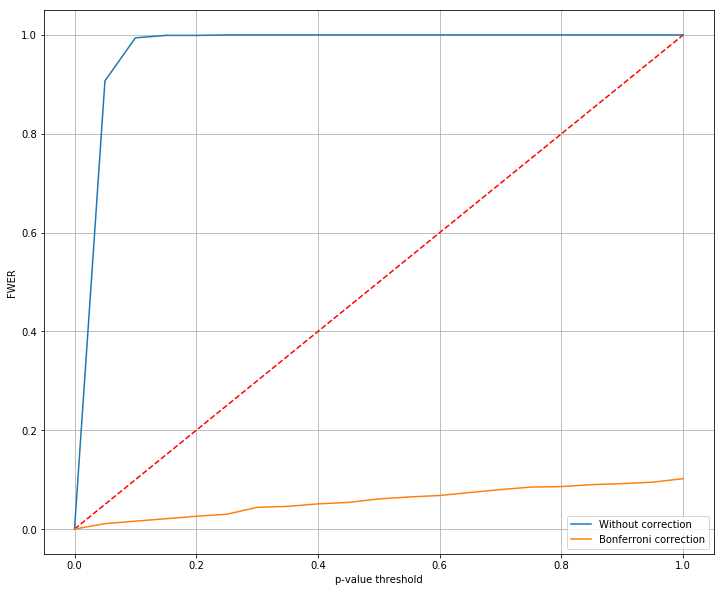

In [33]:
generator=partial(mcomp_simulate_data, 0, 1, N, N_same, (20, 25))
b, s, th=fwer_plot(generator, 1000)